In [42]:
import pandas as pd

orig_data = pd.read_csv('../data/orig_cancer_data.csv')

In [2]:
from sdv.metadata import SingleTableMetadata

# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(orig_data)
# metadata.save_to_json('cancer_metadata.json')

metadata = SingleTableMetadata.load_from_json('../data/cancer_metadata.json')

In [73]:
from sdv.single_table import CTGANSynthesizer

synthesizer = CTGANSynthesizer(
    metadata,
    embedding_dim=1280,
    generator_dim=(1280, 1280),
    discriminator_dim=(1280, 1280),
    generator_lr=1.5e-4,
    generator_decay=0.5e-6,
    discriminator_lr=2e-4,
    discriminator_decay=0.6e-6,
    epochs=5000,
    verbose=True,
)
synthesizer.fit(orig_data)

# synthesizer = CTGANSynthesizer.load('../models/synthesizer.pkl')

Gen. (-2.82) | Discrim. (-1.42): 100%|██████████| 5000/5000 [05:32<00:00, 15.05it/s]


<Axes: xlabel='Epoch', ylabel='Loss'>

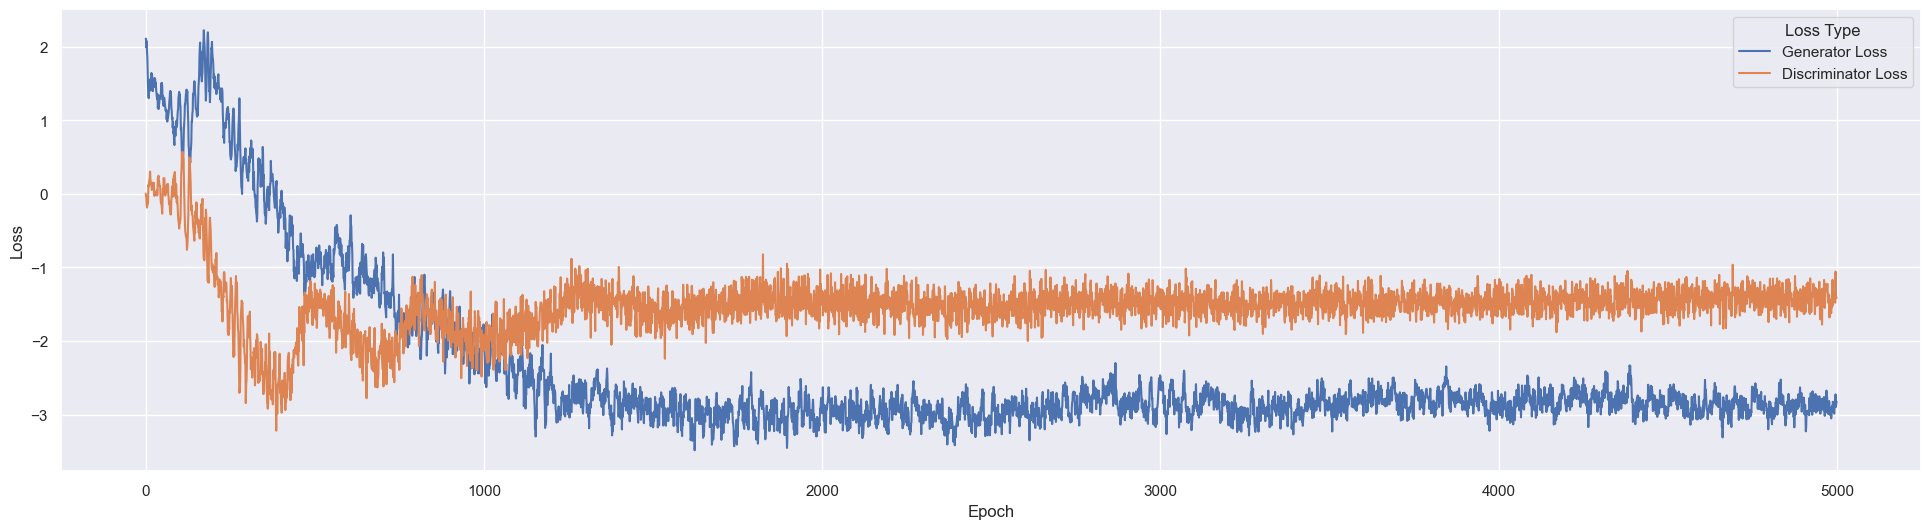

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

plt.figure(figsize=(24, 6))
sns.lineplot(
    synthesizer.get_loss_values().melt(id_vars='Epoch', var_name='Loss Type', value_name='Loss'),
    x='Epoch', y='Loss',
    hue='Loss Type',
)

In [28]:
synthesizer.save('synthesizer.pkl')

In [77]:
from sdv.evaluation.single_table import evaluate_quality

sample = synthesizer.sample(250, batch_size=500)
synth_data = pd.concat([orig_data, sample], ignore_index=True).drop_duplicates()
# synth_data = pd.read_csv('../data/cancer_data.csv')
# synth_data = synthesizer.sample(1100, batch_size=500).drop_duplicates()
report = evaluate_quality(orig_data, synth_data, metadata)
synth_data.info()

Sampling rows: 100%|██████████| 250/250 [00:00<00:00, 976.07it/s]


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 2000.11it/s]|
Column Shapes Score: 95.31%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:04<00:00, 55.39it/s]|
Column Pair Trends Score: 80.39%

Overall Score (Average): 87.85%

<class 'pandas.core.frame.DataFrame'>
Index: 401 entries, 0 to 401
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       401 non-null    int64 
 1   Gender                    401 non-null    object
 2   Air Pollution             401 non-null    int64 
 3   Alcohol Usage             401 non-null    int64 
 4   Dust Allergy              401 non-null    int64 
 5   Occupational Hazards      401 non-null    int64 
 6   Genetic Risk              401 non-null    int64 
 7   Chronic Lung Disease      401 non-null    int64 
 8   Balanced Diet             401 non-null    int64 
 9   Obesity            

In [78]:
evaluate_quality(pd.read_csv('../data/cancer_data.csv'), synth_data, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:02<00:00, 10.52it/s]| 
Column Shapes Score: 93.68%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:25<00:00, 10.85it/s]|
Column Pair Trends Score: 78.77%

Overall Score (Average): 86.23%



In [63]:
synth_data.to_csv('../data/small_cancer_data.csv', index=False)